### Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pickle 
import seaborn as sns 
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import auc

from utils.metrics import *
from utils.utils import visualize

### Pre-loads and paths

In [2]:
from utils.parameters import (
    CLASSES, DEVICE, CLASS_DISTRIBUTION_FOLDER, MD_FOLDER
)

NUM_CLASSES = len(CLASSES)
class_names = [f'{cls} ({idx})' for idx, cls in enumerate(CLASSES)]
figure_path = 'results/figures'

models = ['pspnet', 'mobilenet', 'resnet101']
model_names = ['PSPNet', 'Deeplab Mobilenet', 'Deeplab Resnet101']

datasets = ['cityscapes-val', 'bdd-usa', 'bdd-israel', 'kitti-train', 'kitti-val', 'a2d2']
dataset_names = ['Cityscapes Val', 'BDD100K USA', 'BDD100K Israel', 'KITTI Train', 'KITTI Val', 'A2D2']
thresholds = 60 

# Add a marker for the first point where the risk is less than Accepted Risk in the Risk-Coverage curve 
accepted_risk = 0.15
accepted_coverage = 0.50 


### Visualize the covariance 

* Through the class conditional covariance matrices
* And Pearson correlation matrix

In [3]:
def extract_vectors(pickle_correct_pixel_file): 
    correct_pixels = pickle.load(open(pickle_correct_pixel_file, "rb"))
    
    mean_vectors = []
    cov_vectors = []
    corr_class_numpy = []
    samples = 1000000
    for cls in correct_pixels: 
        samples = min(samples, cls.shape[1]) 

    for cls in tqdm(range(len(CLASSES))): 
        corr_class_numpy.append(correct_pixels[cls][:, 0:samples])
        mean_vectors.append(correct_pixels[cls].mean(axis=1))
        cov_vectors.append(np.cov(correct_pixels[cls]))
        
    corr_class_numpy = np.array(corr_class_numpy)
    mean_vectors = np.array(mean_vectors)
    
    return mean_vectors, cov_vectors, corr_class_numpy


def compute_correlation(corr_class_numpy):
    # Initialize empty 19x19 correlation and p-value matrices
    correlation_matrix = np.zeros((19, 19))
    p_value_matrix = np.zeros((19, 19))

    # Loop through all pairs of classes to compute correlation coefficients and p-values
    for i in range(19):
        for j in range(i, 19):
            correlation, p_value = pearsonr(corr_class_numpy[i, j, :], corr_class_numpy[j, i, :])
            
            # Fill in the correlation and p-value matrices
            correlation_matrix[i, j] = correlation
            correlation_matrix[j, i] = correlation
            p_value_matrix[i, j] = p_value
            p_value_matrix[j, i] = p_value
    
    return correlation_matrix, p_value_matrix


In [4]:
covariance_and_correlations = {}

for model in models:
    pickle_correct_pixel_file = os.path.join(CLASS_DISTRIBUTION_FOLDER, '{}_class_distribution.pickle'.format(model))

    mean_vectors, cov_vectors, corr_class_numpy = extract_vectors(pickle_correct_pixel_file)
    correlation_matrix, p_value_matrix = compute_correlation(corr_class_numpy)

    covariance_and_correlations[model] = {}
    covariance_and_correlations[model]['mean_vectors'] = mean_vectors
    covariance_and_correlations[model]['cov_vectors'] = cov_vectors
    covariance_and_correlations[model]['corr_class_numpy'] = corr_class_numpy
    covariance_and_correlations[model]['correlation_matrix'] = correlation_matrix
    covariance_and_correlations[model]['p_value_matrix'] = p_value_matrix

100%|██████████| 19/19 [00:02<00:00,  8.24it/s]


/tmp/ipykernel_1314127/141794992.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


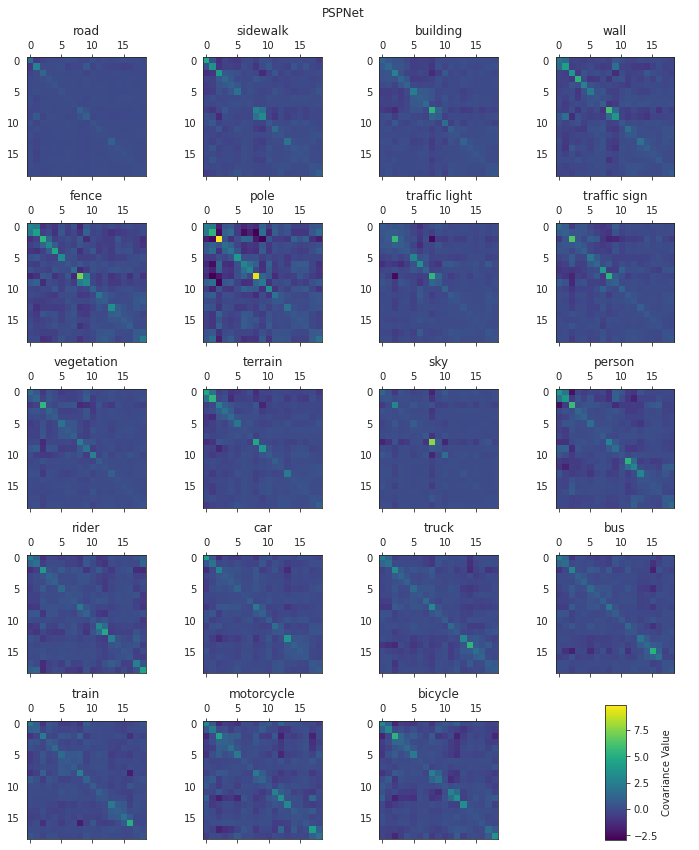

/tmp/ipykernel_1314127/141794992.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


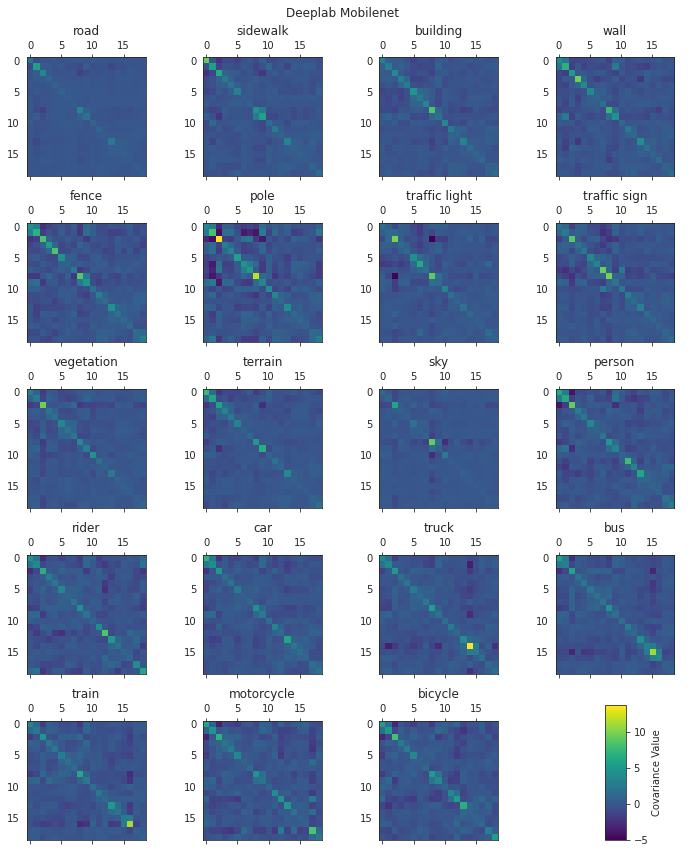

/tmp/ipykernel_1314127/141794992.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


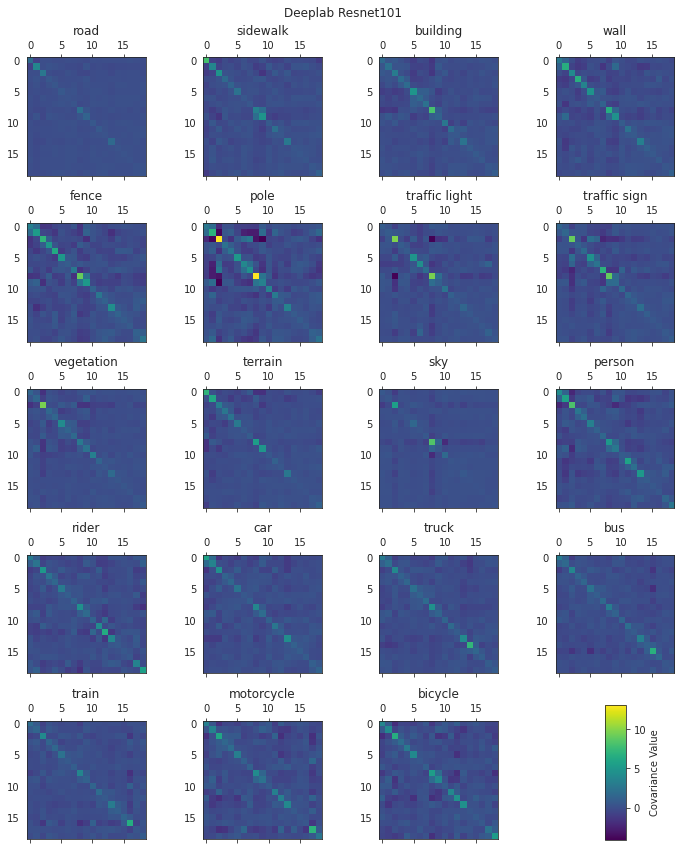

In [5]:
for model, model_name in zip(models, model_names): 
    # Calculate the global min and max values for the color map
    cov_vectors = covariance_and_correlations[model]['cov_vectors']
    vmin = np.array(cov_vectors).min()
    vmax = np.array(cov_vectors).max()

    # Create the figure and subplots
    sns.set_style('white')
    fig, axs = plt.subplots(5, 4, figsize=(10, 12))

    # Flatten the axes for easier iteration
    axs = axs.flatten()

    # Iterate over the covariance matrices and subplots
    for i, (cov, ax) in enumerate(zip(cov_vectors, axs)):
        # Plot the matshow image
        im = ax.matshow(cov, vmin=vmin, vmax=vmax, cmap='viridis')
        
        # Set the subplot title
        ax.set_title(CLASSES[i])
        
        
    # Adjust the spacing between the subplots
    axs[-1].axis('off')

    # Add a colorbar for the subplots
    pos1 = axs[18].get_position()
    pos2 = axs[15].get_position()
    fig.suptitle(model_name)
    bar_width = 0.03
    bar_height = pos1.width


    cbar_ax = fig.add_axes([pos2.x1-bar_width, pos1.y0-bar_height*0.70, bar_width, bar_height])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Covariance Value')

    # Show the plot
    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, f'{model}_covariance_matrices.pdf'), dpi=300)
    plt.show()

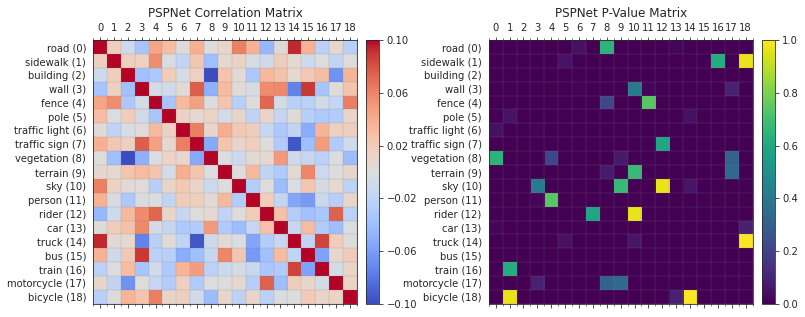

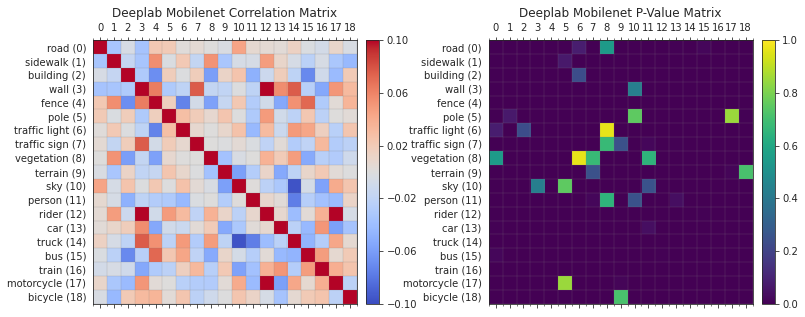

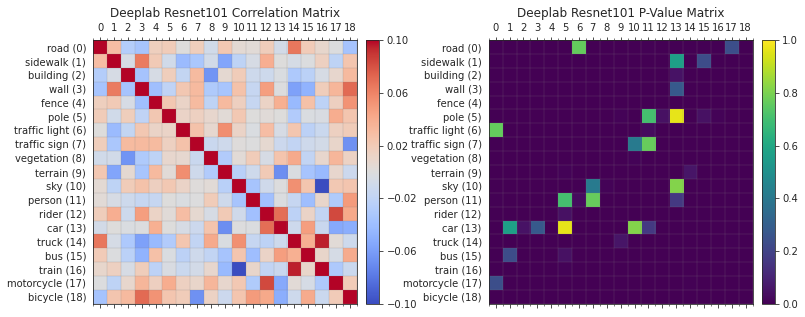

In [6]:
for model, model_name in zip(models, model_names): 
    fig, axs = plt.subplots(1, 2, figsize=(13, 6))
    correlation_matrix = covariance_and_correlations[model]['correlation_matrix']
    p_value_matrix = covariance_and_correlations[model]['p_value_matrix']
    
    # Plot the correlation matrix
    cax1 = axs[0].matshow(correlation_matrix, cmap=plt.cm.coolwarm, vmin=-0.1, vmax=0.1)
    axs[0].set_title(f"{model_name} Correlation Matrix")
    axs[0].set_xticks(np.arange(p_value_matrix.shape[0]+1)-0.5, minor=True)
    axs[0].set_yticks(np.arange(p_value_matrix.shape[1]+1)-0.5, minor=True)
    axs[0].grid(which='minor', color='grey', linestyle='-', linewidth=0.2)
    colorbar1 = fig.colorbar(cax1, ax=axs[0], ticks=np.linspace(-.1, .1, 6))

    # Get the position of the matrix plot and adjust the colorbar position
    pos = axs[0].get_position()
    colorbar1.ax.set_position([pos.x0 + pos.width + 0.01, pos.y0, 0.03, pos.height])

    # Plot the p-value matrix
    cax2 = axs[1].matshow(p_value_matrix, cmap=plt.cm.viridis, vmin=0, vmax=1)
    axs[1].set_title(f"{model_name} P-Value Matrix")
    axs[1].set_xticks(np.arange(p_value_matrix.shape[0]+1)-0.5, minor=True)
    axs[1].set_yticks(np.arange(p_value_matrix.shape[1]+1)-0.5, minor=True)
    axs[1].grid(which='minor', color='grey', linestyle='-', linewidth=0.2)

    colorbar2 = fig.colorbar(cax2, ax=axs[1], ticks=np.linspace(0, 1, 6))

    # Get the position of the matrix plot and adjust the colorbar position
    pos = axs[1].get_position()
    colorbar2.ax.set_position([pos.x0 + pos.width + 0.01, pos.y0, 0.03, pos.height])

    # Customize the class labels
    for ax in axs:
        ax.set_xticks(range(len(class_names)))
        ax.set_yticks(range(len(class_names)))
        ax.set_yticklabels(class_names)
    # fig.suptitle(model_name)

    #plt.tight_layout()
    fig.savefig(os.path.join(figure_path, f'{model}_pearsonr_correlation.pdf'), dpi=300)
    plt.show()

### Save correlation matrix individually with excluded diagonal (for publication)

In [7]:
%matplotlib agg
for model, model_name in zip(models, model_names): 
    x = 2  # Adjustment value for vmin, vmax. 
    fig, ax = plt.subplots(figsize=(8, 6))
    correlation_matrix = covariance_and_correlations[model]['correlation_matrix']
    p_value_matrix = covariance_and_correlations[model]['p_value_matrix']

    # Exclude diagonal from correlation matrix
    np.fill_diagonal(correlation_matrix, np.nan)

    # Plot the correlation matrix
    cax = ax.matshow(correlation_matrix, cmap=plt.cm.coolwarm, vmin=-0.1*x, vmax=0.1*x)
    ax.set_xticks(np.arange(p_value_matrix.shape[0]+1)-0.5, minor=True)
    ax.set_yticks(np.arange(p_value_matrix.shape[1]+1)-0.5, minor=True)
    ax.grid(which='minor', color='grey', linestyle='-', linewidth=0.2)

    ax.set_title(f"{model_name} Correlation Matrix (excl. diagonal)")
    colorbar1 = fig.colorbar(cax, ax=ax, ticks=np.linspace(-0.1*x, 0.1*x, 6))

    # Get the position of the matrix plot and adjust the colorbar position
    pos = ax.get_position()
    colorbar1.ax.set_position([pos.x0 + pos.width + 0.01, pos.y0, 0.03, pos.height])

    # Customize the class labels 
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_yticklabels(class_names)

    os.makedirs(figure_path, exist_ok=True)
    fig.savefig(os.path.join(figure_path, f"{model_name} correlation.pdf"), dpi=300, bbox_inches="tight")


In [8]:
%matplotlib agg
x = 10  # Adjustment value for vmin, vmax. 

for model, model_name in zip(models, model_names): 
    fig, ax = plt.subplots(figsize=(8, 6))


    # Exclude diagonal from correlation matrix
    # np.fill_diagonal(correlation_matrix, np.nan)

    # Plot the correlation matrix
    cax = ax.matshow(p_value_matrix, cmap=plt.cm.Reds, vmin=0, vmax=1)
    ax.set_xticks(np.arange(p_value_matrix.shape[0]+1)-0.5, minor=True)
    ax.set_yticks(np.arange(p_value_matrix.shape[1]+1)-0.5, minor=True)
    ax.grid(which='minor', color='grey', linestyle='-', linewidth=0.2)

    ax.set_title(f"{model_name} P-Value Matrix")
    colorbar1 = fig.colorbar(cax, ax=ax, ticks=np.linspace(0, 1, 6))

    # Draw the gridlines

    

    # Customize the class labels 
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_yticklabels(class_names)
    fig.savefig(os.path.join(figure_path, f"{model_name} p-value.pdf"), dpi=300, bbox_inches="tight")


### Visualize the risk-coverage plots 

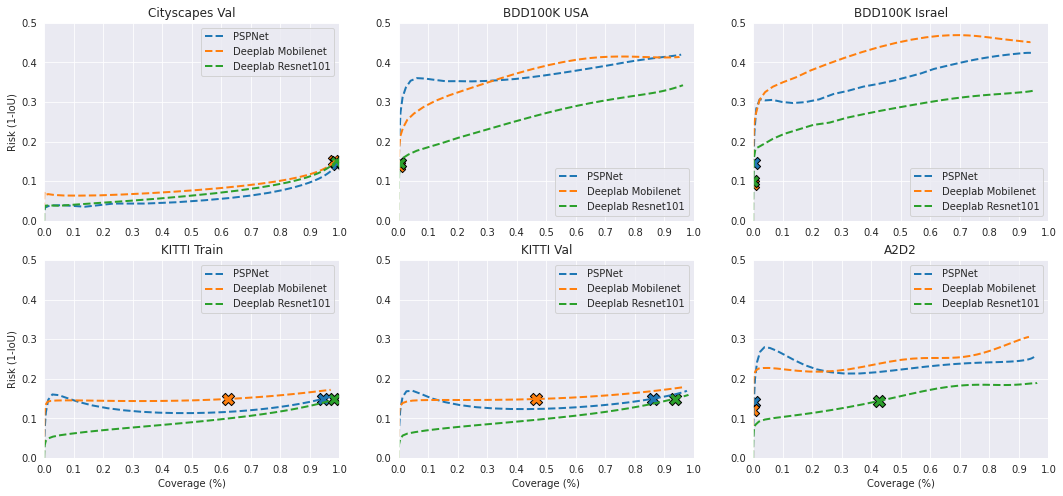

In [9]:
%matplotlib inline
sns.set_style('darkgrid')
colors = sns.color_palette()

# Create the figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 8))
axs = axs.flatten() 

loc = ['best', 'lower right', 'lower right', 'best', 'best', 'best']

table_results_accepted_risk = np.zeros((len(models), len(datasets)))
for midx, model_name in enumerate(models):          
    for idx, dataset_name in enumerate(datasets): 
        # Load the results 
        mahalanobis_results_folder =  os.path.join('{}{}'.format(MD_FOLDER, thresholds), model_name, dataset_name)
        mahalanobis_results = os.path.join(mahalanobis_results_folder, 'mahalanobis_results.npy')        
        dataset_results = np.load(mahalanobis_results)
        risk = dataset_results[:, :, 4] 
        coverage=dataset_results[:, :, 5] 

        # Calcs - Reverse the order to go from 100% coverage to 0%. 
        risk_mean = risk.mean(axis=0)[::-1]
        coverage_mean = coverage.mean(axis=0)[::-1]
        
        sns.lineplot(x=coverage_mean, y=risk_mean, color=colors[midx], linestyle='--', markers='.', linewidth=2, label=model_names[midx], ax=axs[idx])
        sns.scatterplot(x=[coverage_mean[np.argmax(risk_mean < accepted_risk)]], y=[risk_mean[np.argmax(risk_mean < accepted_risk)]],
                        color=colors[midx], marker='X', s=150, edgecolor='black', ax=axs[idx])

        table_results_accepted_risk[midx][idx] = coverage_mean[np.argmax(risk_mean < accepted_risk)]
        
        # Styling: x-labels, y-labe,s etc. 
        if idx >= 3: 
            axs[idx].set_xlabel('Coverage (%)')
        axs[idx].set_title(dataset_names[idx])
        axs[idx].set_ylim(0, 0.5)
        axs[idx].set_xlim(0, 1.0)

        if idx % 3 == 0: 
            axs[idx].set_ylabel('Risk (1-IoU)')
        
        axs[idx].set_xticks(np.arange(0, 1.1, 0.1))
        axs[idx].set_yticks(np.arange(0, 0.6, 0.1))
        axs[idx].legend(loc=loc[idx])
        
fig.savefig(os.path.join(figure_path, "risk_coverage_plots.pdf"), dpi=300, bbox_inches="tight")


### Visualize the adjusted AUROC curves

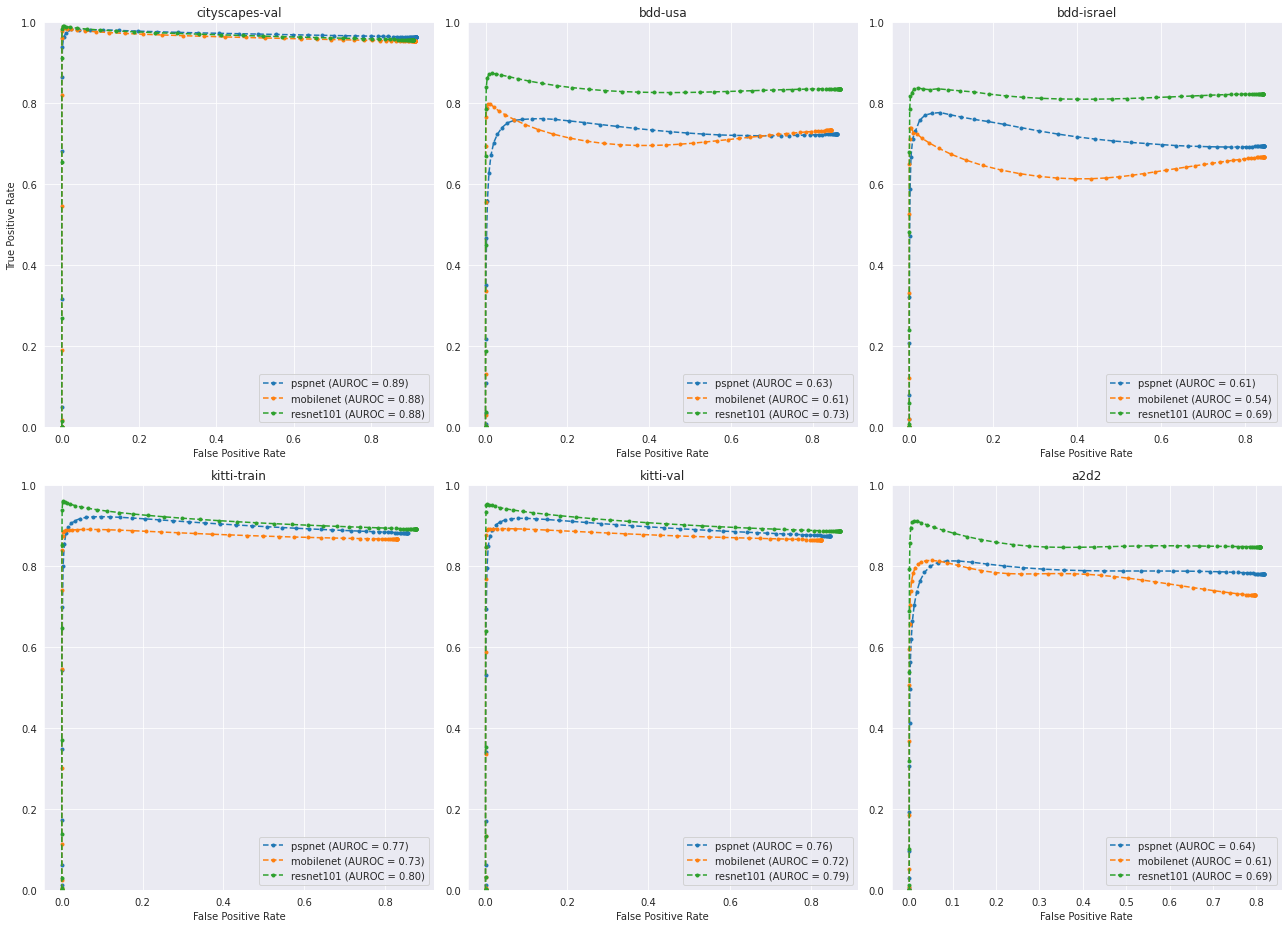

In [10]:
%matplotlib inline
sns.set_style('darkgrid')
colors = sns.color_palette()

# Create the figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 13))
axs = axs.flatten()

table_results_auc = np.zeros((len(models), len(datasets)))

for midx, model_name in enumerate(models): 
    for idx, dataset_name in enumerate(datasets): 
        # Load the results 
        mahalanobis_results_folder =  os.path.join('{}{}'.format(MD_FOLDER, thresholds), model_name, dataset_name)
        mahalanobis_results = os.path.join(mahalanobis_results_folder, 'mahalanobis_results.npy')
        dataset_results = np.load(mahalanobis_results)

        tp = dataset_results[:, :, 0]
        fp = dataset_results[:, :, 1]
        fn = dataset_results[:, :, 2]
        tn = dataset_results[:, :, 3]

        # Calculate TPR and FPR for each threshold
        TPR = tp / (tp + fn + 1e-7)
        FPR = fp / (fp + tn + 1e-7)

        # Calculate mean and standard deviation of TPR and FPR
        TPR_mean = TPR.mean(axis=0)
        FPR_mean = FPR.mean(axis=0)
        
        # Calculate AUROC
        roc_auc = auc(FPR_mean, TPR_mean)
        table_results_auc[midx][idx] = roc_auc

        # Plot TPR against FPR with confidence intervals
        axs[idx].plot(FPR_mean, TPR_mean, '.--', color=colors[midx], label=f'{model_name} (AUROC = {roc_auc:.2f})')
        
        axs[idx].set_xlabel('False Positive Rate')
        axs[idx].set_title(dataset_name)
        axs[idx].set_ylim(0, 1)
        axs[0].set_ylabel('True Positive Rate')
        axs[idx].legend(loc='lower right')

plt.tight_layout()
plt.show()

### Code below to generate LaTeX code for tables and dataset visualizations.  

In [11]:
from utils.dataloaders.cityscapes import cityscapes_loader, kitti_loader
from utils.dataloaders.bdd100k import bdd100k_loader
from utils.dataloaders.audi import a2d2_loader
from utils.preprocessing import * 
from utils.parameters import IMAGE_DIMS

In [12]:
preprocessing_fn = get_preprocessing_fn()  

for midx, model_name in enumerate(['pspnet']):  # Just need to do it once. 
    for idx, dataset_name in enumerate(datasets):             
            width = IMAGE_DIMS[dataset_name]['width']
            height = IMAGE_DIMS[dataset_name]['height']
            if dataset_name == 'cityscapes-train': 
                dataset_loader = cityscapes_loader(preprocessing_fn=get_preprocessing(preprocessing_fn), augmentation_fn=get_validation_augmentation(height=height, width=width), dataset='train')
            elif dataset_name == 'cityscapes-val': 
                dataset_loader = cityscapes_loader(preprocessing_fn=get_preprocessing(preprocessing_fn), augmentation_fn=get_validation_augmentation(height=height, width=width), dataset='validation')
            elif dataset_name == 'bdd-usa':  # The BDD100K subset of data from USA.
                dataset_loader = bdd100k_loader(preprocessing_fn=get_preprocessing(preprocessing_fn), augmentation_fn=get_validation_augmentation(height=height, width=width), dataset='usa')
            elif dataset_name == 'bdd-israel':  # The BDD100K Subset of data from Israel 
                dataset_loader = bdd100k_loader(preprocessing_fn=get_preprocessing(preprocessing_fn), augmentation_fn=get_validation_augmentation(height=height, width=width), dataset='israel')
            elif dataset_name == 'kitti-train':
                dataset_loader = kitti_loader(preprocessing_fn=get_preprocessing(preprocessing_fn), augmentation_fn=get_validation_augmentation(height=height, width=width), dataset='train')
            elif dataset_name == 'kitti-val':
                dataset_loader = kitti_loader(preprocessing_fn=get_preprocessing(preprocessing_fn), augmentation_fn=get_validation_augmentation(height=height, width=width), dataset='validation')
            elif dataset_name == 'a2d2':
                dataset_loader = a2d2_loader(preprocessing_fn=get_preprocessing(preprocessing_fn), augmentation_fn=get_validation_augmentation(height=height, width=width))
            else:
                Warning('Unknown dataset: {}'.format(dataset_name))
                continue
            print(f"{dataset_names[idx]} & {width}x{height} & {len(dataset_loader)} & <DESC>")

Cityscapes Val & 2048x1024 & 500 & <DESC>
BDD100K USA & 1280x720 & 3062 & <DESC>
BDD100K Israel & 1280x720 & 362 & <DESC>
KITTI Train & 1408x376 & 49004 & <DESC>
KITTI Val & 1408x376 & 12276 & <DESC>
A2D2 & 1920x1208 & 41277 & <DESC>


In [13]:
#table_results_accepted_risk
#table_results_auc

datasets_with_training = ['cityscapes-train'] + datasets
latex_table = [['' for j in range(3 * 3 + 1)] for i in range(len(datasets_with_training))]  # 3 models * 3 metrics + 1 name for the dataset 

def get_mean_iou(accuracy_file_path): 
    with open(accuracy_file_path, 'r') as f:
        lines = f.readlines()
        last_line = lines[-1]
        mean_iou = last_line.split(':')[-1].replace('%', '\%').strip()
        return(mean_iou)

for mi, model in enumerate(models): 
    for di, dataset in enumerate(datasets):
        accuracy_file_path = os.path.join('results', 'accuracy', f'{model}_{dataset}_meanIoU.txt') 
        mean_iou = get_mean_iou(accuracy_file_path)
        # print(mi, di, len(latex_table[mi]))
        latex_table[di+1][mi*3 + 1] = mean_iou
        latex_table[di+1][mi*3 + 2] = f'{table_results_auc[mi][di]:.2f}'


        accepted_risk_coverage = table_results_accepted_risk[mi][di]
        if accepted_risk_coverage > accepted_coverage: 
            latex_table[di+1][mi*3 + 3] = f'{100*accepted_risk_coverage:.2f} (\checkmark)'
        else: 
            latex_table[di+1][mi*3 + 3] = f'{100*accepted_risk_coverage:.2f}' 

# Add extra entries for Cityscapes train 
cityscapes_train = 'cityscapes-train'

for mi, model_name in enumerate(models):          
    # Load the results 
    mahalanobis_results_folder =  os.path.join('{}{}'.format(MD_FOLDER, thresholds), model_name, cityscapes_train)
    mahalanobis_results = os.path.join(mahalanobis_results_folder, 'mahalanobis_results.npy') 
    dataset_results = np.load(mahalanobis_results)
    
    accuracy_file_path = os.path.join('results', 'accuracy', f'{model}_{cityscapes_train}_meanIoU.txt') 
    mean_iou = get_mean_iou(accuracy_file_path)

    tp = dataset_results[:, :, 0]
    fp = dataset_results[:, :, 1]
    fn = dataset_results[:, :, 2]
    tn = dataset_results[:, :, 3]
    risk = dataset_results[:, :, 4] 
    coverage=dataset_results[:, :, 5] 

    # Calculate TPR and FPR for each threshold
    TPR = tp / (tp + fn + 1e-7)
    FPR = fp / (fp + tn + 1e-7)

    # Calculate mean and standard deviation of TPR and FPR
    TPR_mean = TPR.mean(axis=0)
    FPR_mean = FPR.mean(axis=0)
    risk_mean = risk.mean(axis=0)[::-1]
    coverage_mean = coverage.mean(axis=0)[::-1]    
        
    # Calculate AUROC
    roc_auc = auc(FPR_mean, TPR_mean)
    coverage = coverage_mean[np.argmax(risk_mean < accepted_risk)]
    latex_table[0][mi*3 + 1] = mean_iou
    latex_table[0][mi*3 + 2] = f'{roc_auc:.2f}'

    if coverage > accepted_coverage: 
        latex_table[0][mi*3 + 3] = f'{100*coverage:.2f} (\checkmark)'
    else: 
        latex_table[0][mi*3 + 3] = f'{100*coverage:.2f}' 
 
all_dataset_names = ['Cityscapes Train'] + dataset_names
for idx, row in enumerate(latex_table):
    latex_table[idx][0] = all_dataset_names[idx]
    print(' & '.join(row))

Cityscapes Train & 85.53\% & 0.92 & 99.48 (\checkmark) & 85.53\% & 0.92 & 99.50 (\checkmark) & 85.53\% & 0.91 & 99.66 (\checkmark)
Cityscapes Val & 82.48\% & 0.89 & 99.19 (\checkmark) & 80.05\% & 0.88 & 98.18 (\checkmark) & 80.95\% & 0.88 & 98.67 (\checkmark)
BDD100K USA & 46.86\% & 0.63 & 0.08 & 47.57\% & 0.61 & 0.06 & 57.45\% & 0.73 & 0.61
BDD100K Israel & 45.07\% & 0.61 & 0.16 & 42.01\% & 0.54 & 0.01 & 57.31\% & 0.69 & 0.07
KITTI Train & 74.41\% & 0.77 & 94.59 (\checkmark) & 71.66\% & 0.73 & 62.22 (\checkmark) & 76.10\% & 0.80 & 98.31 (\checkmark)
KITTI Val & 72.81\% & 0.76 & 86.19 (\checkmark) & 70.92\% & 0.72 & 46.36 & 74.73\% & 0.79 & 93.48 (\checkmark)
A2D2 & 59.38\% & 0.64 & 0.27 & 52.82\% & 0.61 & 0.01 & 68.77\% & 0.69 & 42.66


### Visualize images for paper

In [14]:
from utils.preprocessing import * 
preprocessing_fn = get_preprocessing_fn()  

dataset_vis = ['cityscapes-val', 'bdd-israel', 'kitti-train', 'a2d2']
images = {}
for idx, dataset_name in enumerate(dataset_vis):             
    width = IMAGE_DIMS[dataset_name]['width']
    height = IMAGE_DIMS[dataset_name]['height']
    if dataset_name == 'cityscapes-val': 
        dataset_loader = cityscapes_loader(preprocessing_fn=None, augmentation_fn=get_visualization_augmentation(), dataset='validation')
    elif dataset_name == 'bdd-israel':  # The BDD100K Subset of data from Israel 
        dataset_loader = bdd100k_loader(preprocessing_fn=None, augmentation_fn=get_visualization_augmentation(), dataset='israel')
    elif dataset_name == 'kitti-train':
        dataset_loader = kitti_loader(preprocessing_fn=None, augmentation_fn=get_visualization_augmentation(), dataset='train')
    elif dataset_name == 'a2d2':
        dataset_loader = a2d2_loader(preprocessing_fn=None, augmentation_fn=get_visualization_augmentation())
    
    image, _ = iter(dataset_loader).next()
    images[dataset_name] = image.squeeze().numpy() 


In [15]:
from PIL import Image
def dict_vis(images):

    n = len(images.keys())
    plt.figure(figsize=(16, 5))
    for i, key in enumerate(images.keys()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(key.split('_')).title())
        plt.imshow(images[key])
    plt.show()

(376, 752, 3)
(376, 668, 3)
(376, 1408, 3)
(376, 598, 3)


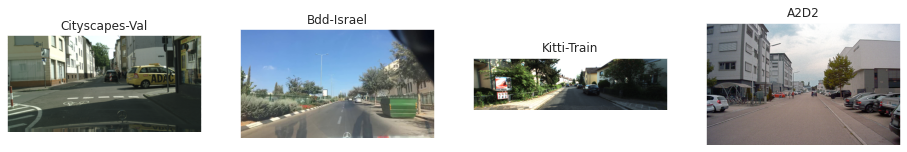

In [16]:
for i, key in enumerate(images.keys()):
    print(images[key].shape)
dict_vis(images)

### Extracting hypothetical FSR1 risk Elicitation to hit coverage critera

In [17]:

for midx, model_name in enumerate(models): 
    risks = []
    for idx, dataset_name in enumerate(datasets): 
        # Load the results 
        mahalanobis_results_folder =  os.path.join('{}{}'.format(MD_FOLDER, thresholds), model_name, dataset_name)
        mahalanobis_results = os.path.join(mahalanobis_results_folder, 'mahalanobis_results.npy')        
        dataset_results = np.load(mahalanobis_results)
        risk = dataset_results[:, :, 4] 
        coverage=dataset_results[:, :, 5] 

        # Calcs - Reverse the order to go from 100% coverage to 0%. 
        risk_mean = risk.mean(axis=0)[::-1]
        coverage_mean = coverage.mean(axis=0)[::-1]
        
        risks.append(risk_mean[np.argmax(coverage_mean < accepted_coverage)])
        
    print(model_name, risks)


pspnet [0.04642214981839579, 0.36719998860234104, 0.3538323698824314, 0.11312303450116694, 0.12402174289657071, 0.22080397594375403]
mobilenet [0.0731309354867153, 0.3829962921181775, 0.44945154854422503, 0.14435913954849142, 0.1485752024613218, 0.24299773566225483]
resnet101 [0.062095527234406186, 0.2611383114828586, 0.2858722367372459, 0.08799647987873686, 0.09677218521689479, 0.15243504482581446]
